# Regression

## Objectives

### Answer business requirement 1: 
* Using a predictive model to **determine the current Reaming Useful Life (RUL) of any given replaceable part** (in this case an industrial air filter).


## Inputs

* outputs/datasets/transformed/dfTransformedTotal.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* Validation set (features and target)
* ML pipeline to predict RUL
* Labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.model_selection import train_test_split

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    median_absolute_error
    )

# ML algorithms
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


df_total = pd.read_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv')
frame = df_total['Data_No'].iloc[0:len(df_total)]
df_train = df_total[frame < 51].reset_index(drop=True)
df_test = df_total[frame > 50].reset_index(drop=True)
df_total

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,39.4,0.000000,0.327257,0.242340,13.328682,44.9,99.74
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,39.3,0.000000,0.196354,0.242340,13.571021,44.9,99.74
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,39.2,0.000000,0.117813,0.242340,13.813361,44.9,99.74
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,39.1,1.808449,0.794067,0.242340,14.055701,44.9,99.44
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,39.0,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
69682,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
69683,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
69684,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


Extract bins that reach **600 pa** of differential pressure or more in **df_train** dataset

In [5]:
dp_total = df_train['Differential_pressure'].map(float).round(decimals=4)
df_train['Differential_pressure'] = dp_total
n = df_train['Differential_pressure'][0:len(df_train)]
df_train_dp = df_train[n >= 600].reset_index(drop=True)
RUL_extract = df_train_dp['Data_No']
RUL_additional = df_train.loc[df_train['Data_No'].isin(RUL_extract)]
RUL_additional

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
8821,11,14.3772,14.377170,2.665642,57.083999,0.1,158.492533,0.9,62.2,14.37717,14.377170,0.142643,0.142643,62.3,97.60
8822,11,13.1113,13.870806,2.629786,56.964773,0.2,158.492533,0.9,62.1,-1.26591,-0.506364,0.142643,0.285287,62.3,97.81
8823,11,15.0101,14.326536,2.662113,57.093926,0.3,158.492533,0.9,62.0,1.89887,0.455730,0.142643,0.427930,62.3,97.50
8824,11,16.2760,15.106337,2.715114,57.252899,0.4,158.492533,0.9,61.9,1.26591,0.779802,0.142643,0.570573,62.3,97.29
8825,11,16.1856,15.538050,2.743292,57.153539,0.5,158.492533,0.9,61.8,-0.09042,0.431713,0.142643,0.713216,62.3,97.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32279,47,594.5276,588.377825,6.377369,59.103897,104.2,79.246266,0.9,0.4,4.34020,4.099850,0.071322,74.317149,104.6,0.91
32280,47,596.4265,591.597295,6.382826,59.377463,104.3,79.246266,0.9,0.3,1.89890,3.219470,0.071322,74.388470,104.6,0.60
32281,47,598.3254,594.288537,6.387365,59.281707,104.4,79.246266,0.9,0.2,1.89890,2.691242,0.071322,74.459792,104.6,0.28
32282,47,599.6817,596.445802,6.390988,58.996220,104.5,79.246266,0.9,0.1,1.35630,2.157265,0.071322,74.531113,104.6,0.05


Include **additional RUL** variables that have a fully completed test cycle to **increase the total data in the modelling dataframe**
Remove NaN Values

In [6]:
df = pd.concat([df_test, RUL_additional], ignore_index=True)
print(df_train.shape, '= df_train')
print(df_test.shape, '= df_test')
print(df.shape, '= df')
df.sort_values('Data_No', ascending=True)

(33324, 15) = df_train
(36362, 15) = df_test
(40112, 15) = df


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
36362,11,14.37720,14.377170,2.665642,57.083999,0.1,158.492533,0.9,62.2,14.37717,14.377170,0.142643,0.142643,62.3,97.60
36774,11,256.52850,259.896386,5.560283,57.558630,41.3,158.492533,0.9,21.0,-7.50510,-2.245258,0.142643,58.911674,62.3,57.25
36775,11,258.42740,259.308792,5.558020,57.723242,41.4,158.492533,0.9,20.9,1.89890,-0.587595,0.142643,59.054318,62.3,56.93
36776,11,260.32620,259.715755,5.559588,57.481806,41.5,158.492533,0.9,20.8,1.89880,0.406963,0.142643,59.196961,62.3,56.61
36777,11,264.03360,261.442893,5.566216,57.448899,41.6,158.492533,0.9,20.7,3.70740,1.727138,0.142643,59.339604,62.3,55.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36059,100,35.71687,34.417504,3.538565,82.979898,22.2,316.985065,1.2,38.0,0.18085,0.866244,0.380382,84.444821,52.4,94.05
36058,100,35.53602,33.551260,3.513074,82.937616,22.1,316.985065,1.2,38.1,1.71802,1.323173,0.380382,84.064439,52.4,94.08
36057,100,33.81800,32.228087,3.472838,82.717792,22.0,316.985065,1.2,38.2,1.26592,1.059942,0.380382,83.684057,52.4,94.36
36068,100,36.98278,36.914036,3.608592,82.650156,23.1,316.985065,1.2,37.1,1.26591,0.045829,0.380382,87.868260,52.4,93.84


# MP Pipeline: Regressor

## Convert Ordinal Numbers into Categorical Values
The target and all requirements are already in a numerical format (float and integer) from our previous engineering steps. 
* **Notwithstanding**; we will convert the **dust type** back into a categorical variable to demonstrate the inclusion of a categorical encoder in each pipeline.
* We will also take the opportunity to remove **data number** from the regression set. 
    * This variable is a category and may confound the results as each RUL measure is within a series of data bins of 'not always complete' tests.

In [7]:
# data_no = df['Data_No'].map(str)
# df.drop(['Data_No'], axis=1)
dust = df['Dust'].map(str)
df['Dust'] = dust
df = df.drop(['Data_No'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40112 entries, 0 to 40111
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Differential_pressure  40112 non-null  float64
 1   4point_EWM             40112 non-null  float64
 2   log_EWM                40112 non-null  float64
 3   Flow_rate              40112 non-null  float64
 4   Time                   40112 non-null  float64
 5   Dust_feed              40112 non-null  float64
 6   Dust                   40112 non-null  object 
 7   RUL                    40112 non-null  float64
 8   change_DP              40112 non-null  float64
 9   change_EWM             40112 non-null  float64
 10  mass_g                 40112 non-null  float64
 11  cumulative_mass_g      40112 non-null  float64
 12  Tt                     40112 non-null  float64
 13  filter_balance         40112 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.3+ MB


## Create ML pipeline

In [8]:

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Dust'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Differential_pressure', '4point_EWM', 'log_EWM',
                                                                'Flow_rate', 'Time', 'Dust_feed',
                                                                'change_DP', 'change_EWM', 'mass_g',
                                                                'cumulative_mass_g', 'Tt','filter_balance'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base


Custom Class for hyperparameter optimisation

In [9]:
# from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score (R²)'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score (R²)': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score (R²)', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train, Test and Validation Sets

In [10]:
# from sklearn.model_selection import train_test_split

X_working, X_test, y_working, y_test = train_test_split(
    df.drop(['RUL'], axis=1),
    df['RUL'],
    test_size=0.25,
    random_state=8,
    shuffle=True
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_working,
    y_working,
    test_size=0.25,
    random_state=8,
    shuffle=True
)

print('\n', X_train.shape, y_train.shape, '= Train set\n',
      X_validate.shape, y_validate.shape, '= Validation set\n',
      X_test.shape, y_test.shape, '= Test set\n',
      '===========\n',
      df.shape[0], '= Total Observations\n')



 (22563, 13) (22563,) = Train set
 (7521, 13) (7521,) = Validation set
 (10028, 13) (10028,) = Test set
 40112 = Total Observations



In [11]:
X_train

,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
24462,133.734800,134.331774,4.900313,81.043738,186.8,59.107236,1.2,-1.26590,-0.397982,0.070929,132.494780,258.1,77.71
3544,10.760270,10.869038,2.385918,58.458498,21.6,158.492533,1.025,0.00000,-0.072512,0.162455,35.090247,114.5,98.21
35991,10.579430,10.427003,2.344399,82.624780,15.4,316.985065,1.2,0.00000,0.101618,0.380382,58.578840,52.4,98.24
14097,132.468900,132.970680,4.890129,81.551023,140.9,59.107236,1.025,-1.26590,-0.334520,0.060585,85.364148,257.9,77.92
21472,50.636570,48.466935,3.880882,83.137331,103.5,59.107236,1.2,2.89352,1.446423,0.070929,73.411187,243.8,91.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15672,37.073210,39.693105,3.681177,81.483387,41.2,59.107236,0.9,-4.34027,-1.746596,0.053197,21.916963,145.7,93.82
20659,2.260561,1.741581,0.554793,82.548697,22.2,59.107236,1.2,0.00000,0.345987,0.070929,15.746168,243.8,99.62
7457,7.414641,7.121340,1.963096,58.151218,48.0,79.246266,1.025,0.00000,0.195534,0.081227,38.989163,115.1,98.76
24256,100.368900,100.519461,4.610351,81.491846,166.2,59.107236,1.2,0.00000,-0.100374,0.070929,117.883471,258.1,83.27


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [12]:
models_quick_search = {
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    'LinearRegression': LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "SGDRegressor": SGDRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "AdaBoostRegressor": {},
    "DecisionTreeRegressor": {},
    "ExtraTreesRegressor": {},
    "GradientBoostingRegressor": {},
    'LinearRegression': {},
    "RandomForestRegressor": {},
    "SGDRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Define the Color Map

In [14]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis']
# cmap = plt.cm.RdBu

Check results

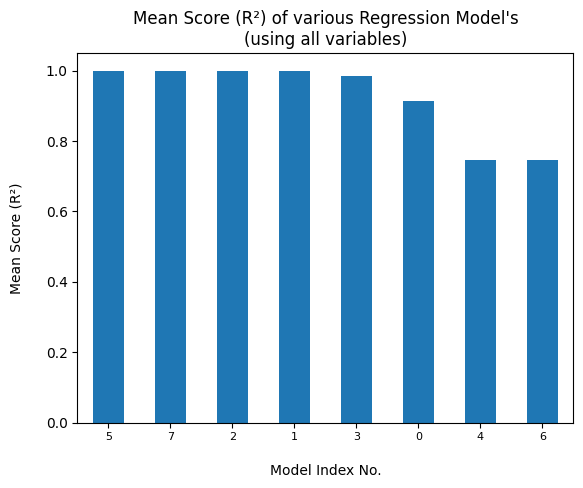

,estimator,min_score,mean_score (R²),max_score,std_score
5,RandomForestRegressor,0.997664,0.997743,0.997813,0.000052
7,XGBRegressor,0.997578,0.997652,0.997732,0.000059
2,ExtraTreesRegressor,0.99751,0.997609,0.997669,0.00006
1,DecisionTreeRegressor,0.997327,0.997464,0.997516,0.000069
3,GradientBoostingRegressor,0.982152,0.983226,0.984276,0.000744
0,AdaBoostRegressor,0.908245,0.9126,0.915833,0.002687
4,LinearRegression,0.745012,0.746857,0.750444,0.002034
6,SGDRegressor,0.745002,0.746738,0.750485,0.002029


In [15]:
# import matplotlib.pyplot as plt
# %matplotlib inline

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score (R²)')
results = grid_search_summary['mean_score (R²)']
results.plot(kind="bar",title="Mean Scores (R²)")

axes = plt.gca()
axes.set_ylim([0.0,1.05])
plt.xticks(rotation=0, fontsize=8)

plt.title("Mean Score (R²) of various Regression Model's\n(using all variables)")
plt.ylabel('Mean Score (R²)\n')
plt.xlabel('\nModel Index No.')
plt.show()
grid_search_summary

The average **R² score** (mean_score) indicates how well a model of the data fits the actual data. 

We note that
* From the **original 6 features**, plus an additional **8 calculated** ones, produces an almost perfect prediction of remaining useful life (RUL).
    * R² score ranges from **0.74** to **0.99**, which is exceptional, as value of 1 represents a perfect fit.
    * This is result is exceptional, however unusual and requires further investigation.
    * The natural inter-correlation of the calculated requirements may be influencing the models score, so we will exclude these for further review.
* The **Random Forest Regressor** looks to be the best performing model among the 7 reviewed at this stage.

---

## Exclude Calculated Requirements
These are naturally be cross correlated to the base requirement they are calculated and may unduly skew the model.

In [16]:
df.head(3)

,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,2.622251,1.159577,0.148056,55.524146,0.4,236.428943,1.025,58.6,2.622251,0.975116,0.24234,0.969359,36.6,99.56
1,3.888165,2.251012,0.811380,55.852018,0.5,236.428943,1.025,58.5,1.265914,1.091435,0.24234,1.211698,36.6,99.35
2,4.521122,3.159056,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.632957,0.908044,0.24234,1.454038,36.6,99.25


Consolidate columns required in **Dataframe**, **Train**, **Test** & **Validation** Sets

In [17]:
columns_req = ['Differential_pressure', 'Flow_rate', 'Time', 'Dust_feed', 'Dust', 'RUL']
df = df.filter(columns_req)
X_train = X_train.filter(columns_req)
X_validate = X_validate.filter(columns_req)
X_test = X_test.filter(columns_req)

print('\n', X_train.shape, y_train.shape, '= Train set\n',
      X_validate.shape, y_validate.shape, '= Validate set\n',
      X_test.shape, y_test.shape, '= Test set\n',
      '===========\n',
      df.shape[0], '= Total Observations\n')
      
df.head(3)


 (22563, 5) (22563,) = Train set
 (7521, 5) (7521,) = Validate set
 (10028, 5) (10028,) = Test set
 40112 = Total Observations



,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,2.622251,55.524146,0.4,236.428943,1.025,58.6
1,3.888165,55.852018,0.5,236.428943,1.025,58.5
2,4.521122,56.130203,0.6,236.428943,1.025,58.4


## Save for Later
We will take the opportunity to save this **hybrid dataframe** for use in the **feature study** section that looks to answer **business requirement 2**.

In [18]:
df_export = df.copy()
dust_density = ['ISO 12103-1, A2 Fine Test Dust' if n == '0.9' else ('ISO 12103-1, A3 Medium Test Dust' if n == '1.025' else 'ISO 12103-1, A4 Coarse Test Dust') for n in df_export['Dust']]
df_export['Dust'] = dust_density
df_export.to_csv(f'outputs/datasets/transformed/dfCombinedHybrid.csv',index=False)
df_export.head(3)

,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5
2,4.521122,56.130203,0.6,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.4


Simple check to see all dust values have been converted

In [19]:
df_export.Dust.unique().reshape(-1).tolist()

['ISO 12103-1, A3 Medium Test Dust',
 'ISO 12103-1, A2 Fine Test Dust',
 'ISO 12103-1, A4 Coarse Test Dust']

## Re-Define the Pipeline

In [20]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Dust'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Differential_pressure',
                                                                'Flow_rate', 'Time', 'Dust_feed'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Re-Run hyperparameter optimization search using default hyperparameters **on less variables**.

In [21]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

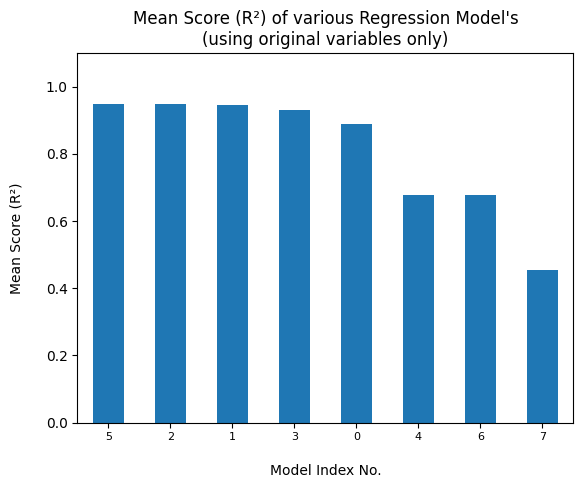

,estimator,min_score,mean_score (R²),max_score,std_score
5,RandomForestRegressor,0.945914,0.948985,0.952097,0.002022
2,ExtraTreesRegressor,0.94378,0.946553,0.949754,0.001972
1,DecisionTreeRegressor,0.941409,0.943693,0.945667,0.001402
3,GradientBoostingRegressor,0.925873,0.929794,0.932074,0.002141
0,AdaBoostRegressor,0.884708,0.887931,0.890165,0.001931
4,LinearRegression,0.674475,0.677149,0.678994,0.002047
6,SGDRegressor,0.67419,0.676939,0.678977,0.002045
7,XGBRegressor,0.428192,0.453144,0.471037,0.01392


In [22]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score (R²)')
results = grid_search_summary['mean_score (R²)']
results.plot(kind="bar",title="Mean Scores (R²)")

axes = plt.gca()
axes.set_ylim([0,1.1])
plt.xticks(rotation=0, fontsize=8)

plt.title("Mean Score (R²) of various Regression Model's\n(using original variables only)")
plt.ylabel('Mean Score (R²)\n')
plt.xlabel('\nModel Index No.')
plt.show()
grid_search_summary

### Observations
* From the **original 6 features** maintains the almost perfect prediction of remaining useful life (RUL) for most regression models.
    * R² score ranges from ±**0.45** to ±**0.95**.
    * We see a slight reduction of the scores across all tests, which is understandable considering the removal of possibly cross correlated calculated variables.
    * There is negligible difference between the top 3 ranked models.

* The **Random Forest Regressor** remains the best performing model with an R² of **0.948985**.
    * This is result is exceptional.
    * High R² Scores are unusual and will require further investigation.

* The R² score of the top 5 ranked estimators is much higher than the **0.7** tolerance we decided in the business case.
    * We could use this information to feedback to the business team to review the business model.
    * A tolerance level between **0.85** to **0.95** or higher may be suitable for this dataset / business case.
    * At the high performance levels seen in a variety of models, the **speed of calculating each model** may also be a further consideration for the business team.

## Optimal **hyperparameter configuration** of the most suitable model
Here we will perform an extensive grid search on the most suitable model to find the optimal combination of hyper-parameters.

First step is to define the model and parameters for the extensive search

#### Random Forest Regressor (12min)

In [23]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

models_search = {
    'RandomForestRegressor': RandomForestRegressor(),
}

params_search = {
    'RandomForestRegressor':{
        # 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # 'model__criterion': ['squared_error', 'friedman_mse', 'poisson'],
        'model__criterion': ['poisson'],
        # # 'model__max_depth': [None],
        # 'model__max_depth': [3,10,None],
        'model__max_features': [1.0, 'sqrt', 'log2'],
        # 'model__n_estimators': [100,300,600,29089],
        'model__n_estimators': [100,400,800],
        # 'model__n_jobs': [None, 1],
        # 'model__n_jobs': [None],
    }
}

Extensive GridSearch CV

In [24]:
search_regr = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_regr.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/workspace/.pip-modules/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Check results

In [25]:
grid_search_summary, grid_search_pipelines = search_regr.score_summary(sort_by='mean_score (R²)')
grid_search_summary

,estimator,min_score,mean_score (R²),max_score,std_score,model__criterion,model__max_features,model__n_estimators
4,RandomForestRegressor,0.945989,0.949231,0.952622,0.002163,poisson,sqrt,400
5,RandomForestRegressor,0.945947,0.949218,0.95253,0.002152,poisson,sqrt,800
8,RandomForestRegressor,0.945934,0.949197,0.952445,0.00214,poisson,log2,800
7,RandomForestRegressor,0.945906,0.949191,0.95242,0.002141,poisson,log2,400
1,RandomForestRegressor,0.945984,0.949153,0.952456,0.002127,poisson,1.0,400
6,RandomForestRegressor,0.945923,0.949149,0.952135,0.00208,poisson,log2,100
2,RandomForestRegressor,0.946048,0.949141,0.952332,0.002069,poisson,1.0,800
3,RandomForestRegressor,0.945695,0.949069,0.952323,0.002161,poisson,sqrt,100
0,RandomForestRegressor,0.945807,0.949037,0.952243,0.002108,poisson,1.0,100


---

#### Extra Trees Regressor (48min)

In [26]:
# # documentation to help on hyperparameter list: 
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

# models_search = {
#     'ExtraTreesRegressor': ExtraTreesRegressor(),
# }

# params_search = {
#     'ExtraTreesRegressor':{
#         'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#         # # 'model__max_depth': [None],
#         # 'model__max_depth': [3,10,None],
#         # 'model__max_features': [1.0, 'sqrt', 'log2'],
#         # model__min_samples_split': [2,4,6],
#         # 'model__n_estimators': [100,200,300],
#         # 'model__n_jobs': [None, 1],
#     }
# }

Extensive GridSearch CV

In [27]:
# search_et = HyperparameterOptimizationSearch(models=models_search, params=params_search)
# search_et.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=2)

Check Results

In [28]:
# grid_search_summary_ExtraTrees, grid_search_pipelines_ExtraTrees = search_et.score_summary(sort_by='mean_score (R²)')
# grid_search_summary_ExtraTrees

Concatenation into a summary

In [29]:
# grid_search_summary = pd.concat([grid_search_summary_RForest, grid_search_summary_ExtraTrees], ignore_index=True)
# grid_search_pipelines = dict(grid_search_summary_RForest); grid_search_pipelines.update(grid_search_summary_ExtraTrees)

---

#### Check the best model

In [30]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestRegressor'

Hyperparameters for best model

In [31]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__criterion': 'poisson',
 'model__max_features': 'sqrt',
 'model__n_estimators': 400}

Define the best regressor, based on search

In [32]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='sqrt',
                                       n_estimators=400))])

## Assess feature importance

Recall best Parameters

In [33]:
best_parameters

{'model__criterion': 'poisson',
 'model__max_features': 'sqrt',
 'model__n_estimators': 400}

Manually define these into the best model

In [34]:
reg_model = RandomForestRegressor(
    criterion='poisson',
    max_features='sqrt',
    n_estimators=400,
    )
reg_model.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_features='sqrt',
                      n_estimators=800)

Visualize results

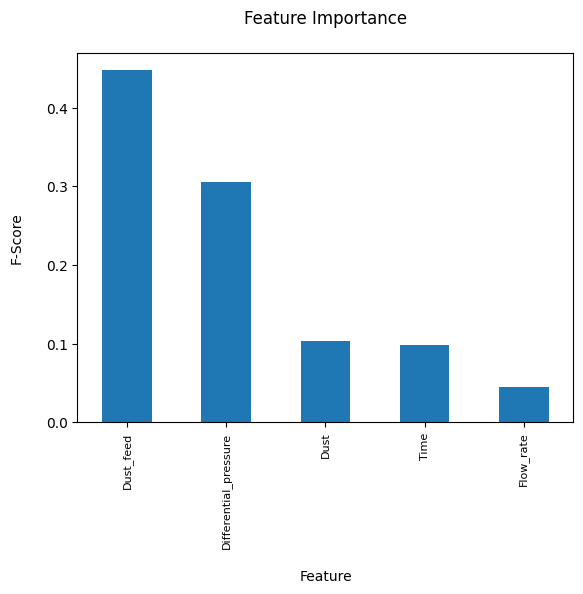

In [35]:
feat_importances = (pd.Series(reg_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))
plt.xticks(fontsize=8)
plt.title('Feature Importance\n')
plt.ylabel("F-Score\n")
plt.xlabel('\nFeature')
plt.show()

#### Observations
* From the 6 original features, we dropped `Data_No` as it is a catagorical variable that arbitrarily describes the test number and has no relation to the patterns seen in the dataset.
* Among the remaing 5 variables, 2 show higher relevance to predict Remaining Useful Life (RUL) that the others
    * `Dust Feed` and `Differential Pressure`

---

## Evaluate Regressor Performance on Train and Test Sets

Compute a performance metric on the data held out for testing, **df_test**
* [R² score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) (also called Coefficient of Determination)
* [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (MAE)
* [Median Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html) (MdAE)
* [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE)
* Root Mean Squared Error (RMSE).

We could also consider:
* Almost Correct Predictions Error Rate (ACPER)
* Mean Absolute Percentage Error (MAPE) and 
* Adjusted R² Score 
    * _((1 - R²) * (sample_size - 1)) * -1 / (sample_size - no_independent_features - 1))_

Define Evaluation Functions

In [36]:
# from sklearn.metrics import (
#     r2_score, mean_squared_error, mean_absolute_error,
#     median_absolute_error
#     )
# import numpy as np
# import seaborn as sns

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R² Score:', r2_score(y, prediction).round(4))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(4))
    print('Median Absolute Error:', median_absolute_error(y, prediction).round(4))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(4))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(4))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Run Performance Evaluation

Model Evaluation 

* Train Set
R² Score: 0.9768
Mean Absolute Error: 6.6629
Median Absolute Error: 3.6913
Mean Squared Error: 111.8182
Root Mean Squared Error: 10.5744


* Test Set
R² Score: 0.9521
Mean Absolute Error: 9.4972
Median Absolute Error: 5.5174
Mean Squared Error: 228.0249
Root Mean Squared Error: 15.1005




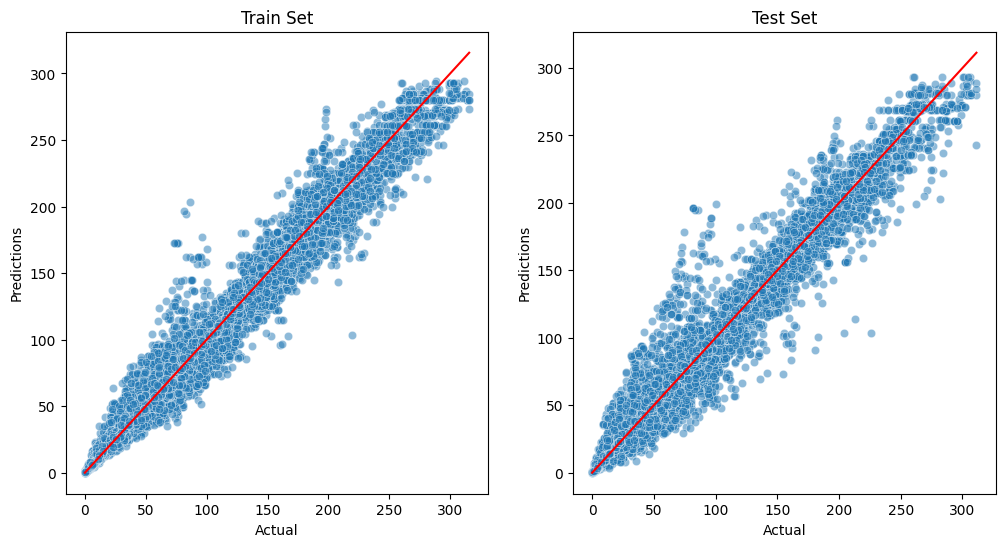

In [37]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [38]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='sqrt',
                                       n_estimators=400))])

#### Observations
* The pipeline performance (R² Score) Train set: ±**0.97** and Test set: ±**0.95**.
* The represents a very high performance of the model to predict remaining useful life.
* This is much higher than the current business requirement is an R² Score of 0.7 or higher.
* Our hyperparameter combination exceeds our performance criteria.

Additionally:
* The predictions tend to follow the actual values.
* We initially added more hyperparameters in the extensive search.
* Optimal hyperparameter combinations were chosen to train all possible models more quickly.
* We see a few outliers in the supplied dataset that tend to mirror each other, reflecting the sourcing of train, test data from the same data bins.

#### Considerations
* Due to the high performance of this model, additional hyperparameters are not warranted to increase performance in this case.
* We could replace the **feature selection step** in the model pipeline for a **PCA (Principal Component Analysis) step** to select variables according to the magnitude (from largest to smallest in absolute values) of their coefficients (loadings).
    * In this case, we already have a small number of attributes and performance exceeds the current business case requirement, so a PCA is not warranted, however;
    * To **demonstrate the process** we will perform a PCA and **highlight any changes** that occur in performance.

Next:
* Refit our ML Pipeline with a PCA.


---

# Regressor with PCA

Review PCA separately to the scaled data

In [39]:
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor())])
pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)
print(f'RandomForrestRegression (defaults): {r2}') # RFR: 0.9997308011141385

RandomForrestRegression (defaults): 0.9944268522844631


In [40]:
pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor(
    criterion='poisson',
    max_features='sqrt',
    n_estimators=800,
))])
pipeline.fit(X_train, y_train)

r2 = pipeline.score(X_test, y_test)
print(f'RandomForrestRegression (custom x 3): {r2}') # 0.999761456617107

RandomForrestRegression (custom x 3): 0.9942399920451498


* All components explain ±**99%** of the data 
* Just 3 of these components also explain **99%** of the data

Apply PCA separately to the scaled data

In [41]:
# pipeline = PipelineOptimization(model=RandomForestRegressor(random_state=0))
# pipeline_pca = Pipeline(pipeline.steps[:4])
# # df_pca = pipeline_pca.fit_transform(df.drop(['Data_No'], axis=1))
# df_pca = pipeline_pca.fit_transform(X_train, y_train)

In [42]:
# # import numpy as np
# # import seaborn as sns
# # from sklearn.decomposition import PCA

# n_components = 3

# def pca_components_analysis(df_pca, n_components):
#     pca = PCA(n_components=n_components).fit(df_pca)
#     x_PCA = pca.transform(df_pca)  # array with transformed PCA

#     ComponentsList = ["Component " + str(number)
#                       for number in range(n_components)]
#     dfExplVarRatio = pd.DataFrame(
#         data=np.round(100 * pca.explained_variance_ratio_, 3),
#         index=ComponentsList,
#         columns=['Explained Variance Ratio (%)'])

#     dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
#     )

#     PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
#     )

#     print(
#         f"* The {n_components} components explain {round(PercentageOfDataExplained,4)}% of the data \n")
#     plt.figure(figsize=(12, 5))
#     sns.lineplot(data=dfExplVarRatio,  marker="o")
#     plt.xticks(rotation=90)
#     plt.yticks(np.arange(0, 110, 10))
#     plt.show()


# pca_components_analysis(df_pca=df_pca, n_components=n_components)


In [43]:
# n_components = 2
# pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [44]:
from sklearn.decomposition import PCA

n_components = 3

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        
        # ("filter_and_split", filter_and_split(df)),

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Dust'])),
                                                     
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Differential_pressure',
                                                                'Flow_rate', 'Time', 'Dust_feed'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        # PCA replace Feature Selection
        # ("feat_selection",  SelectFromModel(model)),
        ("PCA", PCA(n_components=n_components, random_state=0)),
        ("model", model),
    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [45]:
print('Summary:\n', X_train.shape, y_train.shape, '= Train set\n', X_test.shape, y_test.shape, '= Test set')

Summary:
 (22563, 5) (22563,) = Train set
 (10028, 5) (10028,) = Test set


### Use standard hyperparameters to find the most suitable model.

In [46]:
models_quick_search = {
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    'LinearRegression': LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "SGDRegressor": SGDRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "AdaBoostRegressor": {},
    "DecisionTreeRegressor": {},
    "ExtraTreesRegressor": {},
    "GradientBoostingRegressor": {},
    'LinearRegression': {},
    "RandomForestRegressor": {},
    "SGDRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimisation search 

In [47]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [48]:
grid_search_summary_PCA, grid_search_pipelines_PCA = quick_search.score_summary(sort_by='mean_score (R²)')
grid_search_summary_PCA

,estimator,min_score,mean_score (R²),max_score,std_score
5,RandomForestRegressor,0.984396,0.985974,0.986586,0.000805
7,XGBRegressor,0.984413,0.985794,0.986622,0.00075
2,ExtraTreesRegressor,0.984043,0.98521,0.985727,0.000601
1,DecisionTreeRegressor,0.976139,0.977135,0.977615,0.000524
3,GradientBoostingRegressor,0.970467,0.971058,0.971848,0.000515
0,AdaBoostRegressor,0.904459,0.910273,0.915362,0.004364
4,LinearRegression,0.683709,0.700922,0.710891,0.009383
6,SGDRegressor,0.683549,0.700702,0.710235,0.009288


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [49]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

models_search = {
    'RandomForestRegressor': RandomForestRegressor(),
}

params_search = {
    'RandomForestRegressor':{
        # 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # 'model__criterion': ['squared_error', 'friedman_mse', 'poisson'],
        'model__criterion': ['poisson'],
        # # 'model__max_depth': [None],
        # 'model__max_depth': [3,10,None],
        'model__max_features': [1.0, 'sqrt', 'log2'],
        # 'model__n_estimators': [100,300,600,29089],
        'model__n_estimators': [100,400,800],
        # 'model__n_jobs': [None, 1],
        # 'model__n_jobs': [None],
    }
}

Extensive GridSearch CV

In [50]:
search_PCA = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_PCA.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [51]:
grid_search_summary_PCA, grid_search_pipelines_PCA = search_PCA.score_summary(sort_by='mean_score (R²)')
grid_search_summary_PCA

,estimator,min_score,mean_score (R²),max_score,std_score,model__criterion,model__max_features,model__n_estimators
8,RandomForestRegressor,0.98499,0.986326,0.986754,0.000673,poisson,log2,800
7,RandomForestRegressor,0.98491,0.986297,0.986771,0.000699,poisson,log2,400
5,RandomForestRegressor,0.984948,0.986288,0.986733,0.000675,poisson,sqrt,800
4,RandomForestRegressor,0.984951,0.986277,0.986711,0.000669,poisson,sqrt,400
6,RandomForestRegressor,0.984991,0.986225,0.986652,0.000622,poisson,log2,100
3,RandomForestRegressor,0.984849,0.986205,0.986627,0.000682,poisson,sqrt,100
2,RandomForestRegressor,0.984506,0.986067,0.986634,0.000793,poisson,1.0,800
1,RandomForestRegressor,0.984503,0.986052,0.986591,0.000784,poisson,1.0,400
0,RandomForestRegressor,0.984497,0.985995,0.986473,0.000761,poisson,1.0,100


Check the best model

In [52]:
best_model = grid_search_summary_PCA.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [53]:
grid_search_pipelines_PCA[best_model].best_params_

{'model__criterion': 'poisson',
 'model__max_features': 'log2',
 'model__n_estimators': 800}

Define the best regressor

In [54]:
best_regressor_pipeline = grid_search_pipelines_PCA[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=3, random_state=0)),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='log2',
                                       n_estimators=800))])

Visualize most important features

In [55]:
reg_model = RandomForestRegressor(
    criterion='poisson',
    max_features='sqrt',
    n_estimators=800,
    )
reg_model.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_features='sqrt',
                      n_estimators=800)

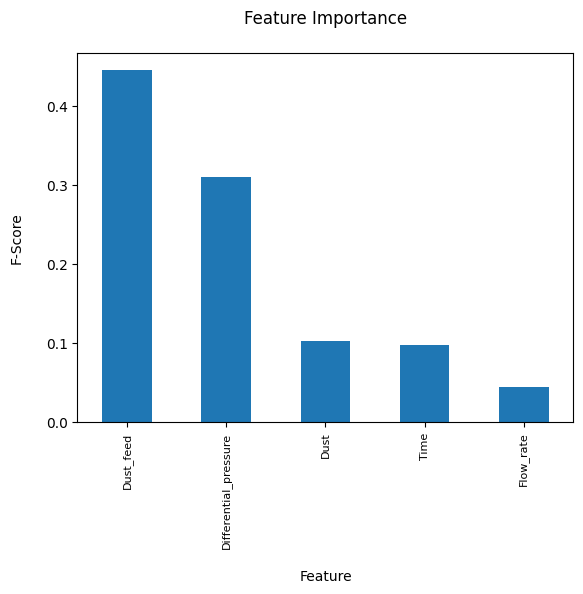

In [56]:
feat_importances = (pd.Series(reg_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))
plt.xticks(fontsize=8)
plt.title('Feature Importance\n')
plt.ylabel("F-Score\n")
plt.xlabel('\nFeature')
plt.show()

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R² Score: 0.998
Mean Absolute Error: 1.752
Median Absolute Error: 0.7151
Mean Squared Error: 9.5957
Root Mean Squared Error: 3.0977


* Test Set
R² Score: 0.987
Mean Absolute Error: 4.4716
Median Absolute Error: 1.803
Mean Squared Error: 61.7708
Root Mean Squared Error: 7.8594




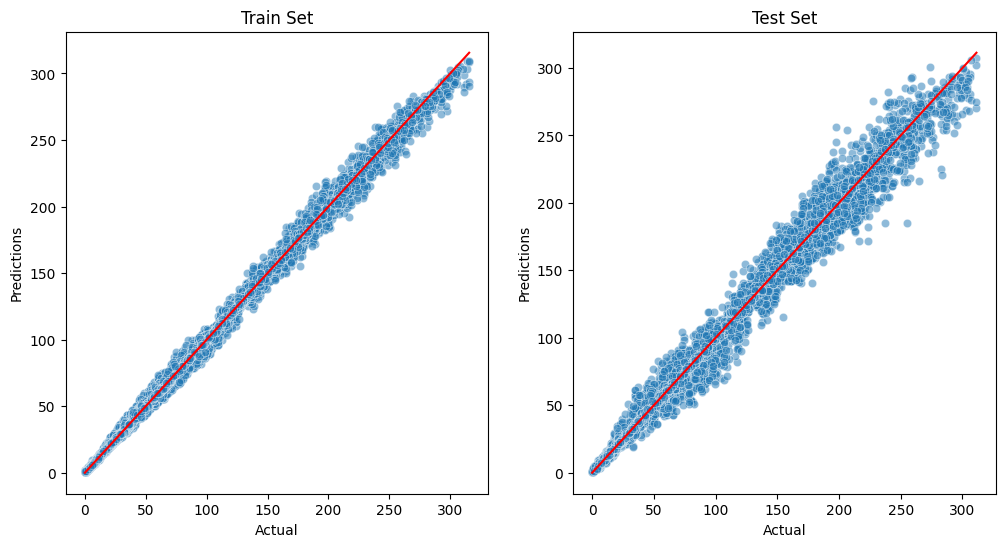

In [57]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Cross Validation

The training accuracy is **99%** and testing accuracy is **98%**.
* The model fits perfectly on the training and testing datasets.

As this is an exceptional case, and for the **purposes of demonstration**, we will undertake a Cross Validation step to demonstrate how we ensure that we do not '**overfit**' and our model fits the data accurately.

If the testing dataset performed poorly, this would be called **overfitting**. In this scenario, the model would learn well on training data however it will **generalize on new data**. When test loss increases as we keep improving training loss, this leads to overfitting.

In [ ]:
stop

# Which pipeline to choose?

We fitted the following pipelines:
* Random Forest Regression (with all variables)
* Random Forest Regression (with original 6 variables)
* Random Forest Regression with PCA
<!-- * Classifier -->

### Observations
All the regressor pipelines exceeded the expected performance threshold (0.7 R² score) for the train and test set.
The 

The Importance of features changed between Regression vs Regression + PCA processes:
* 3 pipeline components explain more than 90% of the data and improves the performance of the model.
* The `max_features` component changes from `log3` to `sqrt` improving all measures of performance.
* The `n_components` component changed from `800` to `400` improving all measures of performance.
* The R² Score is moderately improved.
* Error rates significantly decrease across both **train** and **test** sets.

|| Performance Measure | Regressor | Regressor + PCA |
|---|---|---|---|
|**Train Set**|R² Score:|± 0.97|± 0.99|
||Mean Absolute Error:|± 6.66|± 1.75|
||Median Absolute Error:|± 3.70|± 0.71|
||Mean Squared Error:|± 111.80|± 9.62|
||Root Mean Squared Error:|± 10.57|± 3.10|
|||||
|**Test Set**|R² Score:|± 0.95|± 0.98|
||Mean Absolute Error:|± 9.49|± 4.46|
||Median Absolute Error:|± 5.48|± 1.81|
||Mean Squared Error:|± 227.77|± 61.71|
||Root Mean Squared Error:|± 15.09|± 7.86|

In [58]:
# pipeline_clf
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=3, random_state=0)),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='log2',
                                       n_estimators=800))])

# Refit pipeline with best features

## Rewrite Pipeline

In [59]:
n_components = 2

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=['Dust'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        variables=['Differential_pressure','Dust_feed', 'Time'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
         # ("feat_selection",  SelectFromModel(model)),
        ("PCA", PCA(n_components=n_components, random_state=0)),
        ("model", model),
    ])
    return pipeline_base


## Consolidate Dataset, Train, Test and Validation Set, only with best features

In [60]:
columns_req = ['Differential_pressure', 'Flow_rate', 'Time', 'Dust_feed', 'Dust']
df = df.filter(columns_req)
X_train = X_train.filter(columns_req)
X_validate = X_validate.filter(columns_req)
X_test = X_test.filter(columns_req)

print('\n', X_train.shape, y_train.shape, '= Train set\n',
      X_validate.shape, y_validate.shape, '= Validate set\n',
      X_test.shape, y_test.shape, '= Test set\n',
      '===========\n',
      df.shape[0], '= Total Observations\n')
      
X_train.head(3)


 (22563, 5) (22563,) = Train set
 (7521, 5) (7521,) = Validate set
 (10028, 5) (10028,) = Test set
 40112 = Total Observations



,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
24462,133.73480,81.043738,186.8,59.107236,1.2
3544,10.76027,58.458498,21.6,158.492533,1.025
35991,10.57943,82.624780,15.4,316.985065,1.2


Subset Best Features

In [61]:
best_model

'RandomForestRegressor'

In [62]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Flow_rate', 'Time',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=3, random_state=0)),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='log2',
                                       n_estimators=800))])

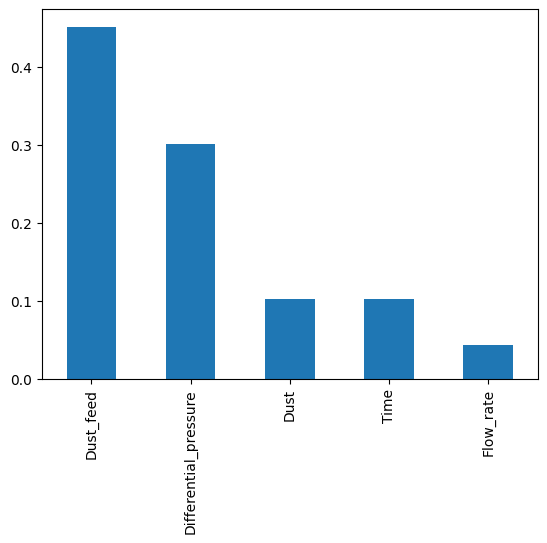

In [63]:
reg_model = RandomForestRegressor(
    criterion='poisson',
    max_features='sqrt',
    n_estimators=800,
    )
reg_model.fit(X_train, y_train)
feat_importances = (pd.Series(reg_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))

Consolidate **Train**, **Test** and **Validation** data by top 3 feature importance

In [64]:
n_features = 3
best_features = pd.Series(reg_model.feature_importances_, index=X_train.columns).nlargest(n_features).index.to_list()
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)
X_validate = X_validate.filter(best_features)

print('Summary:\n', X_train.shape, y_train.shape,'= Train set\n',
        X_validate.shape, y_validate.shape, '= Validation set\n',
        X_test.shape, y_test.shape, '= Test set\n')
X_train.head(6)

Summary:
 (22563, 3) (22563,) = Train set
 (7521, 3) (7521,) = Validation set
 (10028, 3) (10028,) = Test set



,Dust_feed,Differential_pressure,Dust
24462,59.107236,133.73480,1.2
3544,158.492533,10.76027,1.025
35991,316.985065,10.57943,1.2
14097,59.107236,132.46890,1.025
21472,59.107236,50.63657,1.2
22548,59.107236,287.00090,1.2


In [65]:
best_features

['Dust_feed', 'Differential_pressure', 'Dust']

## Grid Search CV – Sklearn

Define Pipeline

In [66]:
n_components = 2

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Dust'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                                        # variables=['Differential_pressure','Dust_feed', 'Time'],
                                                        variables=['Differential_pressure','Dust_feed'],
                                                        method="spearman",
                                                        threshold=0.6,
                                                        selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        #  ("feat_selection",  SelectFromModel(model)),
        ("PCA", PCA(n_components=n_components, random_state=0)),
        ("model", model),
    ])
    return pipeline_base

We are using the same model from the previous GridCV search

In [67]:
models_search

{'RandomForestRegressor': RandomForestRegressor()}

And the best parameters from the previous GridCV search

In [68]:
best_parameters

{'model__criterion': 'poisson',
 'model__max_features': 'sqrt',
 'model__n_estimators': 400}

Include manually

In [69]:
models_search = {
    'RandomForestRegressor': RandomForestRegressor(),
}

params_search = {
    'RandomForestRegressor':{
        'model__criterion': ['poisson'],
        'model__max_features': ['sqrt'],
        'model__n_estimators': [400],
    }
}

GridSearch CV

In [70]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [71]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score (R²)')
grid_search_summary

,estimator,min_score,mean_score (R²),max_score,std_score,model__criterion,model__max_features,model__n_estimators
0,RandomForestRegressor,0.981056,0.981427,0.981859,0.000278,poisson,sqrt,800


Check the best model

In [72]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Define the best clf pipeline

In [73]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=2, random_state=0)),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='sqrt',
                                       n_estimators=800))])

## Assess feature importance

The 3 most important features in descending order. 

The above model was trained on the following variables: 
['Dust_feed', 'Differential_pressure', 'Dust']


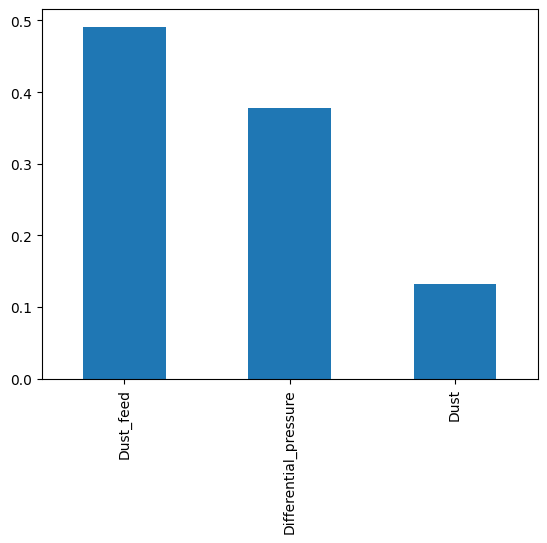

In [74]:
reg_model = RandomForestRegressor(
    criterion='poisson',
    max_features='sqrt',
    n_estimators=400,
    )
reg_model.fit(X_train, y_train)
df_feature_importance = pd.Series(reg_model.feature_importances_, index=X_train.columns).nlargest(n_features).index.to_list()
print(f'The {len(best_features)} most important features in descending order. \n'
      f'\nThe above model was trained on the following variables: \n{df_feature_importance}')
feat_importances = (pd.Series(reg_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))


# Save files to the repo

We will generate the following files to include in the app

* Train set
* Test set
* Validation set
* Modeling pipeline
* Features importance plot

In [75]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_rul/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [76]:
X_train.head()

,Dust_feed,Differential_pressure,Dust
24462,59.107236,133.73480,1.2
3544,158.492533,10.76027,1.025
35991,316.985065,10.57943,1.2
14097,59.107236,132.46890,1.025
21472,59.107236,50.63657,1.2


In [77]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [78]:
y_train

24462    148.4
3544     100.2
35991     44.8
14097    122.3
21472    190.2
         ...  
15672    161.2
20659    271.5
7457     182.2
24256    169.0
29287     66.8
Name: RUL, Length: 22563, dtype: float64

In [79]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [80]:
X_test.head()

,Dust_feed,Differential_pressure,Dust
35815,59.107236,367.929000,1.2
28897,118.214472,70.077400,1.2
11278,59.107236,59.678820,1.025
18222,118.214472,8.228443,1.025
21398,59.107236,42.860240,1.2


In [81]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [82]:
y_test

35815     44.9
28897     81.2
11278    148.7
18222    116.6
21398    197.6
         ...  
18555     83.3
8986     108.1
21530    184.4
32520     32.1
12005     76.0
Name: RUL, Length: 10028, dtype: float64

In [83]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Validation Set: features and target

In [84]:
X_validate.head()

,Dust_feed,Differential_pressure,Dust
27981,79.246266,106.69850,1.2
33025,316.985065,56.42361,0.9
27680,79.246266,63.56699,1.2
31780,177.321707,22.42477,0.9
7633,79.246266,11.21238,1.025


In [85]:
X_validate.to_csv(f"{file_path}/X_validate.csv", index=False)

In [86]:
y_validate

27981    100.4
33025     16.1
27680    130.5
31780     26.5
7633     164.6
         ...  
19850     54.9
23089    285.7
39933     17.8
9717     188.9
32423      6.8
Name: RUL, Length: 7521, dtype: float64

In [87]:
y_validate.to_csv(f"{file_path}/y_validate.csv", index=False)

## Modelling pipeline

ML pipeline for predicting RUL

In [88]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Dust'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['Differential_pressure',
                                                     'Dust_feed'])),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=2, random_state=0)),
                ('model',
                 RandomForestRegressor(criterion='poisson', max_features='sqrt',
                                       n_estimators=800))])

In [89]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/RandomForestRegressor_pipeline.pkl")

['outputs/ml_pipeline/predict_rul/v2/RandomForestRegressor_pipeline.pkl']

## Feature importance plot

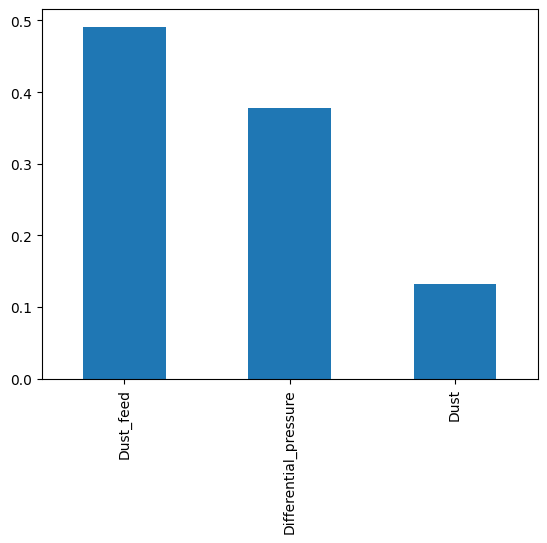

In [90]:
feat_importances = (pd.Series(reg_model.feature_importances_, index=X_train.columns)
                    .nlargest(6)
                    .plot(kind='bar'))
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

C'est Fini

---